<a href="https://colab.research.google.com/github/SeunghyeChae/tmdhey/blob/main/GAN_xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Xray GAN

In [1]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torchvision

- 생성자와 판별자를 연결하는 gan 네트워크를 만듦
 gan(x) = discriminator(generator(x))
- gan 네트워크는 잠재 공간의 벡터를 판별자의 평가로 매핑
- 판별자는 생성자가 잠재 공간의 벡터를 디코딩한 것이 얼마나 현실적인지를 평가
- '진짜'/'가짜' 레이블과 함께 진짜 이미지와 가짜 이미지 샘플을 사용해 판별자를 훈련함. 일반적인 이미지 분류 모델을 훈련하는 것과 동일
- 생성자를 훈련하려면 gan 모델의 손실에 대한 생성자 가중치의 그래디언트를 사용함. (== 매 단계 마다 생성자에 의해 디코딩된 이미지를 판별자가 '진짜'로 분류하도록 만드는 방향으로 생성자의 가중치를 이동한다는 뜻). 즉, 판별자를 속이도록 생성자를 훈련

In [2]:
# 생성자

# input: (batch_size * chs_in * hegith_in * width_in)
# Output: (batch_size, chs_out, hegith_out, width_out)
# h_out = (hegith_in -1) * stride - 2 * padding + kernel

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            # Hidden Layer 1
            nn.ConvTranspose2d(in_channels=100, 
                               out_channels=512,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            
            # Hidden Layer 2
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            
            # Hidden Layer 3
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            # Hidden Layer 4
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            
            # Output Layer
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.main(x)
        return x

In [3]:
# 판별자
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            
            # (batch_size, 1, 64, 64)
            nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=4,
                      stride=2,
                      padding=1, 
                      bias=False),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 64, 32, 32)
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 128, 16, 16)
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 256, 8, 8)
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 512, 4, 4)
            nn.Conv2d(in_channels=512,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),
            
            # (batch_size, 1, 1, 1)
            nn.Sigmoid()
        )
        
        
    def forward(self, x):
        x = self.main(x)
        return x

In [4]:
G = Generator()
G(torch.randn(12, 100, 1, 1)).shape

torch.Size([12, 1, 64, 64])

In [5]:
D = Discriminator()
D(torch.randn(14, 1, 64, 64)).shape

torch.Size([14, 1, 1, 1])

In [6]:
def build_data_loader(batch_size):
    dataset = torchvision.datasets.ImageFolder(
        root='/content/drive/MyDrive/cakd_colab/2차플젝/2차 데이터 원본/데이터 원본/image',
        # root='/content/drive/MyDrive/cakd_colab/python_practice/.kaggle',
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(64), 
            torchvision.transforms.CenterCrop(64), 
            torchvision.transforms.Grayscale(), 
            torchvision.transforms.ToTensor(), 
        ]))
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(images):
    img = torchvision.utils.make_grid(images, normalize=True)
    npy_img = img.numpy()
    plt.imshow(np.transpose(npy_img, (1, 2, 0)),
               interpolation='nearest')
    plt.show()

torch.Size([8, 1, 64, 64])


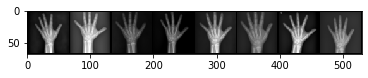

In [8]:
# for data, _ in build_data_loader(5):
#     test_images = data
#     break
    
# print(test_images.shape)
# show_images(test_images)

In [9]:
compute_loss = nn.BCELoss()

In [10]:
# # 얘로하면 좀 이상해요~ 120정도부터 이상해요
# n_epochs = 150
# batch_size = 5

# 이걸로 하면 좀 빠를거같고 
n_epochs = 150
batch_size = 15

# # 이건 그 후에 해볼거예욤
# n_epochs = 100
# batch_size = 5


In [11]:
gpu = torch.device(0)
G = G.to(gpu)
D = D.to(gpu)

In [12]:
optimizer_d = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [13]:
data_loader = build_data_loader(batch_size)
test_noise = torch.randn((8, 100, 1, 1)).to(gpu)

Epoch: 0/150
Example images:


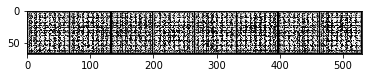

Epoch: 0	Batch: 496/497
Loss G: 9.906012535095215
Loss D: 0.0034130418207496405
Epoch: 1/150
Example images:


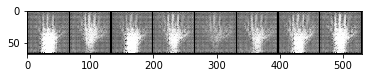

Epoch: 1	Batch: 496/497
Loss G: 7.514601230621338
Loss D: 0.9209915995597839
Epoch: 2/150
Example images:


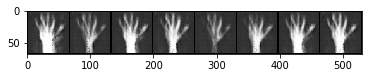

Epoch: 2	Batch: 496/497
Loss G: 5.781625270843506
Loss D: 0.05171101167798042
Epoch: 3/150
Example images:


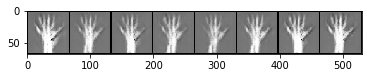

Epoch: 3	Batch: 496/497
Loss G: 6.346251964569092
Loss D: 0.04313574731349945
Epoch: 4/150
Example images:


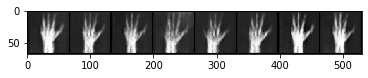

Epoch: 4	Batch: 496/497
Loss G: 5.862499713897705
Loss D: 0.026433860883116722
Epoch: 5/150
Example images:


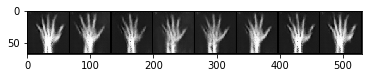

Epoch: 5	Batch: 496/497
Loss G: 4.943065643310547
Loss D: 0.3448512554168701
Epoch: 6/150
Example images:


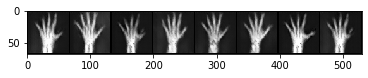

Epoch: 6	Batch: 496/497
Loss G: 4.880626678466797
Loss D: 0.20424781739711761
Epoch: 7/150
Example images:


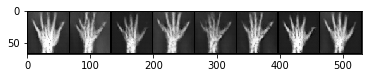

Epoch: 7	Batch: 496/497
Loss G: 5.150367736816406
Loss D: 0.01903044432401657
Epoch: 8/150
Example images:


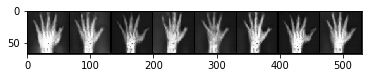

Epoch: 8	Batch: 496/497
Loss G: 7.918550968170166
Loss D: 0.3827107548713684
Epoch: 9/150
Example images:


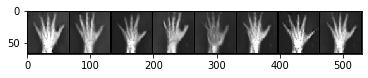

Epoch: 9	Batch: 496/497
Loss G: 4.708049297332764
Loss D: 0.44147631525993347
Epoch: 10/150
Example images:


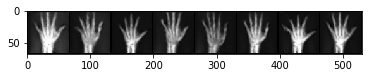

Epoch: 10	Batch: 496/497
Loss G: 5.877114772796631
Loss D: 0.006836744025349617
Epoch: 11/150
Example images:


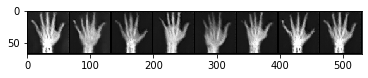

Epoch: 11	Batch: 496/497
Loss G: 6.079884052276611
Loss D: 0.10754010826349258
Epoch: 12/150
Example images:


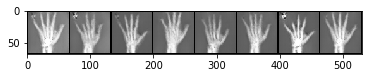

Epoch: 12	Batch: 496/497
Loss G: 6.833335876464844
Loss D: 0.007615441456437111
Epoch: 13/150
Example images:


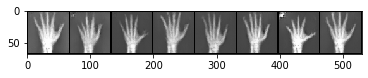

Epoch: 13	Batch: 496/497
Loss G: 5.903178691864014
Loss D: 0.011781396344304085
Epoch: 14/150
Example images:


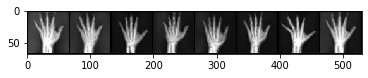

Epoch: 14	Batch: 496/497
Loss G: 8.886606216430664
Loss D: 0.004796991124749184
Epoch: 15/150
Example images:


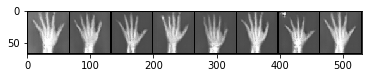

Epoch: 15	Batch: 496/497
Loss G: 5.603696346282959
Loss D: 0.00892273522913456
Epoch: 16/150
Example images:


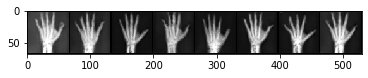

Epoch: 16	Batch: 496/497
Loss G: 7.68343448638916
Loss D: 0.011190472170710564
Epoch: 17/150
Example images:


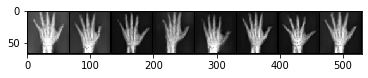

Epoch: 17	Batch: 496/497
Loss G: 5.462491989135742
Loss D: 0.04522126913070679
Epoch: 18/150
Example images:


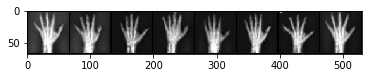

Epoch: 18	Batch: 496/497
Loss G: 14.49084758758545
Loss D: 0.0003826323081739247
Epoch: 19/150
Example images:


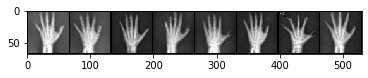

Epoch: 19	Batch: 496/497
Loss G: 7.050854682922363
Loss D: 0.046341683715581894
Epoch: 20/150
Example images:


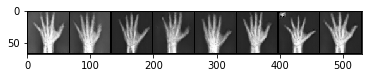

Epoch: 20	Batch: 496/497
Loss G: 2.8110270500183105
Loss D: 3.6115188598632812
Epoch: 21/150
Example images:


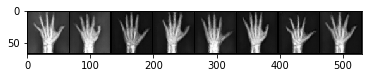

Epoch: 21	Batch: 496/497
Loss G: 7.896745204925537
Loss D: 0.0037875312846153975
Epoch: 22/150
Example images:


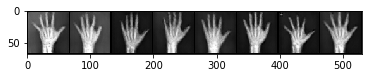

Epoch: 22	Batch: 496/497
Loss G: 5.730987071990967
Loss D: 0.05086720734834671
Epoch: 23/150
Example images:


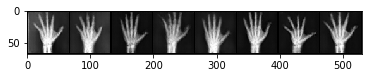

Epoch: 23	Batch: 496/497
Loss G: 5.825386047363281
Loss D: 0.01551087200641632
Epoch: 24/150
Example images:


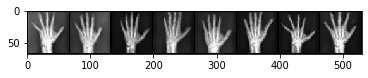

Epoch: 24	Batch: 496/497
Loss G: 8.326024055480957
Loss D: 0.03933535888791084
Epoch: 25/150
Example images:


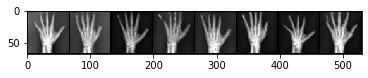

Epoch: 25	Batch: 496/497
Loss G: 6.35164737701416
Loss D: 0.0038724159821867943
Epoch: 26/150
Example images:


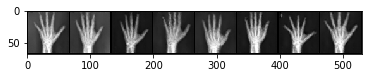

Epoch: 26	Batch: 496/497
Loss G: 5.480053424835205
Loss D: 0.09306274354457855
Epoch: 27/150
Example images:


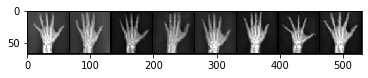

Epoch: 27	Batch: 496/497
Loss G: 9.122939109802246
Loss D: 0.465261846780777
Epoch: 28/150
Example images:


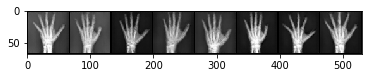

Epoch: 28	Batch: 496/497
Loss G: 9.029141426086426
Loss D: 0.00425050500780344
Epoch: 29/150
Example images:


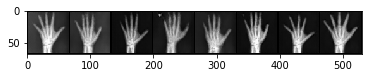

Epoch: 29	Batch: 496/497
Loss G: 4.383077144622803
Loss D: 0.034667082130908966
Epoch: 30/150
Example images:


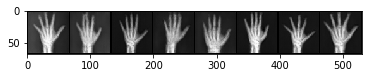

Epoch: 30	Batch: 496/497
Loss G: 5.618772029876709
Loss D: 0.06954854726791382
Epoch: 31/150
Example images:


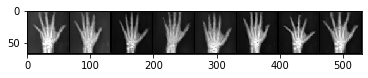

Epoch: 31	Batch: 496/497
Loss G: 3.927236557006836
Loss D: 0.051062118262052536
Epoch: 32/150
Example images:


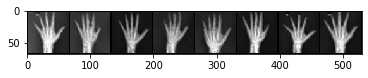

Epoch: 32	Batch: 496/497
Loss G: 9.298802375793457
Loss D: 0.006395003292709589
Epoch: 33/150
Example images:


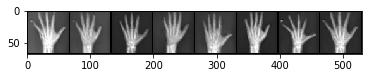

Epoch: 33	Batch: 496/497
Loss G: 4.871926784515381
Loss D: 0.025688517838716507
Epoch: 34/150
Example images:


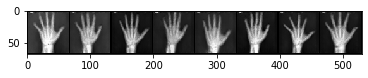

Epoch: 34	Batch: 496/497
Loss G: 9.373496055603027
Loss D: 0.003026623511686921
Epoch: 35/150
Example images:


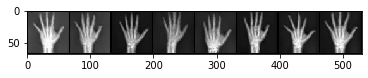

Epoch: 35	Batch: 496/497
Loss G: 10.097696304321289
Loss D: 0.5050398707389832
Epoch: 36/150
Example images:


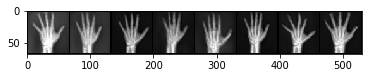

Epoch: 36	Batch: 496/497
Loss G: 9.672118186950684
Loss D: 0.3551120162010193
Epoch: 37/150
Example images:


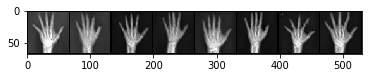

Epoch: 37	Batch: 496/497
Loss G: 11.903504371643066
Loss D: 0.5901171565055847
Epoch: 38/150
Example images:


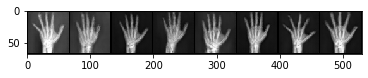

Epoch: 38	Batch: 496/497
Loss G: 13.501070022583008
Loss D: 0.026983870193362236
Epoch: 39/150
Example images:


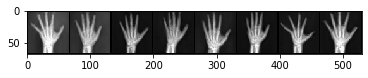

Epoch: 39	Batch: 496/497
Loss G: 13.54119873046875
Loss D: 0.003262624144554138
Epoch: 40/150
Example images:


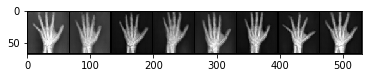

Epoch: 40	Batch: 496/497
Loss G: 10.030355453491211
Loss D: 0.01376553438603878
Epoch: 41/150
Example images:


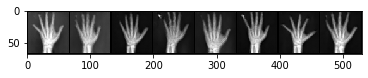

Epoch: 41	Batch: 496/497
Loss G: 8.775578498840332
Loss D: 0.00030941280419938266
Epoch: 42/150
Example images:


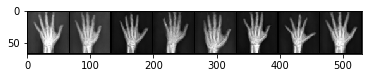

Epoch: 42	Batch: 496/497
Loss G: 8.019652366638184
Loss D: 0.00026690796948969364
Epoch: 43/150
Example images:


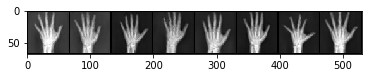

Epoch: 43	Batch: 496/497
Loss G: 7.793580532073975
Loss D: 0.7659783959388733
Epoch: 44/150
Example images:


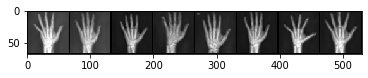

Epoch: 44	Batch: 496/497
Loss G: 15.83830451965332
Loss D: 1.0951496362686157
Epoch: 45/150
Example images:


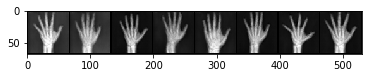

Epoch: 45	Batch: 496/497
Loss G: 12.363917350769043
Loss D: 0.045022930949926376
Epoch: 46/150
Example images:


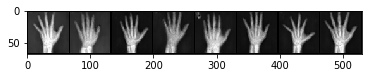

Epoch: 46	Batch: 496/497
Loss G: 10.737947463989258
Loss D: 0.0014399669598788023
Epoch: 47/150
Example images:


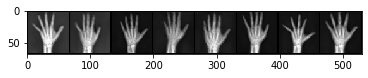

Epoch: 47	Batch: 496/497
Loss G: 11.51132869720459
Loss D: 1.1230295896530151
Epoch: 48/150
Example images:


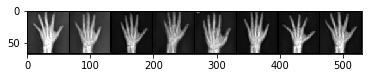

Epoch: 48	Batch: 496/497
Loss G: 14.74797248840332
Loss D: 0.0025667762383818626
Epoch: 49/150
Example images:


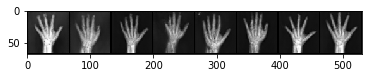

Epoch: 49	Batch: 496/497
Loss G: 6.5145158767700195
Loss D: 0.13173100352287292
Epoch: 50/150
Example images:


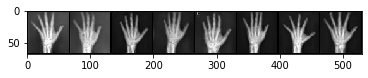

Epoch: 50	Batch: 496/497
Loss G: 8.170469284057617
Loss D: 0.007897675968706608
Epoch: 51/150
Example images:


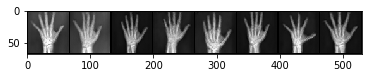

Epoch: 51	Batch: 496/497
Loss G: 15.520410537719727
Loss D: 0.697798490524292
Epoch: 52/150
Example images:


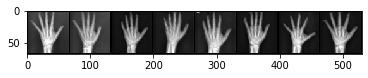

Epoch: 52	Batch: 496/497
Loss G: 12.038171768188477
Loss D: 0.2719501554965973
Epoch: 53/150
Example images:


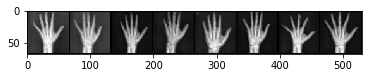

Epoch: 53	Batch: 496/497
Loss G: 10.357100486755371
Loss D: 0.00011655950220301747
Epoch: 54/150
Example images:


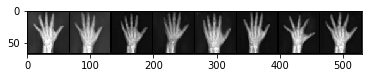

Epoch: 54	Batch: 496/497
Loss G: 5.963578224182129
Loss D: 0.020453734323382378
Epoch: 55/150
Example images:


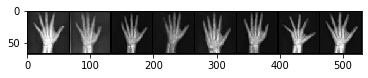

Epoch: 55	Batch: 496/497
Loss G: 6.94734525680542
Loss D: 0.006169701460748911
Epoch: 56/150
Example images:


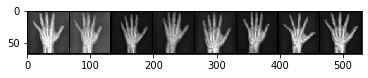

Epoch: 56	Batch: 496/497
Loss G: 7.505982875823975
Loss D: 0.03510793298482895
Epoch: 57/150
Example images:


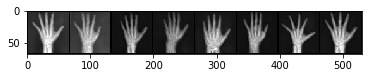

Epoch: 57	Batch: 496/497
Loss G: 4.712649822235107
Loss D: 0.015394930727779865
Epoch: 58/150
Example images:


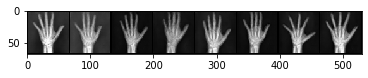

Epoch: 58	Batch: 496/497
Loss G: 6.788707733154297
Loss D: 0.030695442110300064
Epoch: 59/150
Example images:


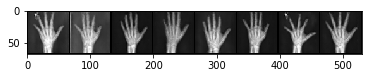

Epoch: 59	Batch: 496/497
Loss G: 9.609965324401855
Loss D: 0.7454228401184082
Epoch: 60/150
Example images:


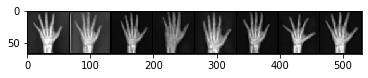

Epoch: 60	Batch: 496/497
Loss G: 5.350849628448486
Loss D: 0.058386094868183136
Epoch: 61/150
Example images:


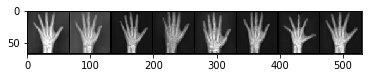

Epoch: 61	Batch: 496/497
Loss G: 5.466080665588379
Loss D: 0.038923025131225586
Epoch: 62/150
Example images:


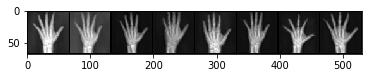

Epoch: 62	Batch: 496/497
Loss G: 7.6447296142578125
Loss D: 0.18903055787086487
Epoch: 63/150
Example images:


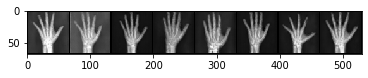

Epoch: 63	Batch: 496/497
Loss G: 9.104151725769043
Loss D: 0.0045911711640655994
Epoch: 64/150
Example images:


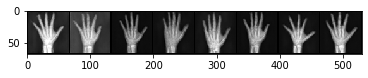

Epoch: 64	Batch: 496/497
Loss G: 2.306936264038086
Loss D: 1.1805285215377808
Epoch: 65/150
Example images:


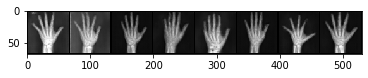

Epoch: 65	Batch: 496/497
Loss G: 10.881683349609375
Loss D: 0.07125749439001083
Epoch: 66/150
Example images:


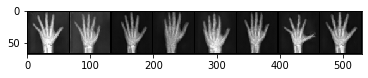

Epoch: 66	Batch: 496/497
Loss G: 14.003952026367188
Loss D: 0.053157757967710495
Epoch: 67/150
Example images:


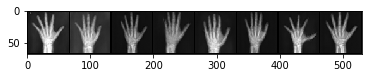

Epoch: 67	Batch: 496/497
Loss G: 11.726435661315918
Loss D: 0.006484562531113625
Epoch: 68/150
Example images:


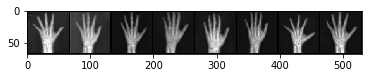

Epoch: 68	Batch: 496/497
Loss G: 8.300207138061523
Loss D: 0.07631168514490128
Epoch: 69/150
Example images:


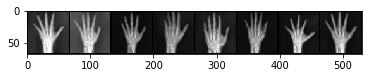

Epoch: 69	Batch: 496/497
Loss G: 13.219367027282715
Loss D: 0.17153437435626984
Epoch: 70/150
Example images:


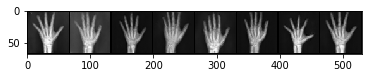

Epoch: 70	Batch: 496/497
Loss G: 13.79883098602295
Loss D: 0.0020442171953618526
Epoch: 71/150
Example images:


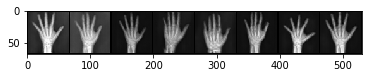

Epoch: 71	Batch: 496/497
Loss G: 10.415185928344727
Loss D: 0.00042394938645884395
Epoch: 72/150
Example images:


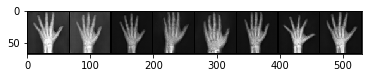

Epoch: 72	Batch: 496/497
Loss G: 7.138978481292725
Loss D: 0.11297086626291275
Epoch: 73/150
Example images:


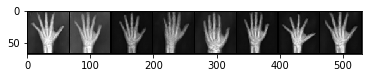

Epoch: 73	Batch: 496/497
Loss G: 7.111279487609863
Loss D: 0.0030898707918822765
Epoch: 74/150
Example images:


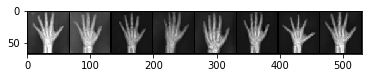

Epoch: 74	Batch: 496/497
Loss G: 8.214808464050293
Loss D: 0.0008715561125427485
Epoch: 75/150
Example images:


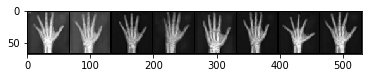

Epoch: 75	Batch: 496/497
Loss G: 13.087203979492188
Loss D: 1.3253839015960693
Epoch: 76/150
Example images:


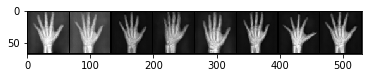

Epoch: 76	Batch: 496/497
Loss G: 10.476799011230469
Loss D: 0.005641636438667774
Epoch: 77/150
Example images:


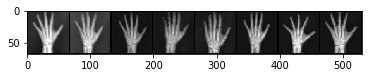

Epoch: 77	Batch: 496/497
Loss G: 5.90584659576416
Loss D: 0.051315877586603165
Epoch: 78/150
Example images:


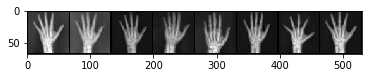

Epoch: 78	Batch: 496/497
Loss G: 7.8112053871154785
Loss D: 0.006152162328362465
Epoch: 79/150
Example images:


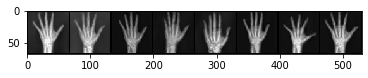

Epoch: 79	Batch: 496/497
Loss G: 8.943814277648926
Loss D: 0.0008638008148409426
Epoch: 80/150
Example images:


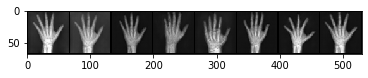

Epoch: 80	Batch: 496/497
Loss G: 13.55774974822998
Loss D: 0.02738502435386181
Epoch: 81/150
Example images:


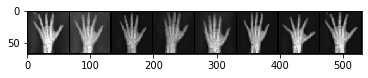

Epoch: 81	Batch: 496/497
Loss G: 6.100745677947998
Loss D: 0.011838077567517757
Epoch: 82/150
Example images:


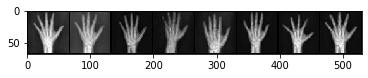

Epoch: 82	Batch: 496/497
Loss G: 4.913520336151123
Loss D: 0.0405120849609375
Epoch: 83/150
Example images:


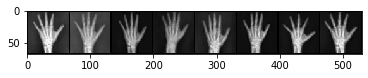

Epoch: 83	Batch: 496/497
Loss G: 8.602496147155762
Loss D: 0.0007774466648697853
Epoch: 84/150
Example images:


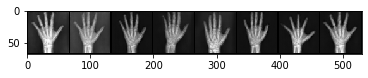

Epoch: 84	Batch: 496/497
Loss G: 10.014372825622559
Loss D: 0.17997455596923828
Epoch: 85/150
Example images:


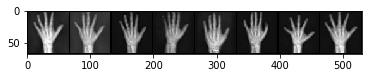

Epoch: 85	Batch: 496/497
Loss G: 6.997813701629639
Loss D: 0.1236657127737999
Epoch: 86/150
Example images:


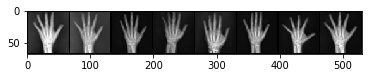

Epoch: 86	Batch: 496/497
Loss G: 12.234330177307129
Loss D: 0.4209251403808594
Epoch: 87/150
Example images:


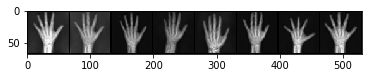

Epoch: 87	Batch: 496/497
Loss G: 12.519104957580566
Loss D: 7.276922406163067e-05
Epoch: 88/150
Example images:


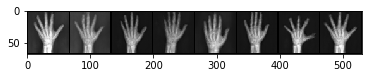

Epoch: 88	Batch: 496/497
Loss G: 5.315009117126465
Loss D: 0.013497975654900074
Epoch: 89/150
Example images:


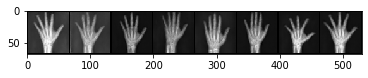

Epoch: 89	Batch: 496/497
Loss G: 26.01472282409668
Loss D: 1.7519367933273315
Epoch: 90/150
Example images:


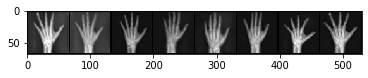

Epoch: 90	Batch: 496/497
Loss G: 6.190911769866943
Loss D: 0.010018888860940933
Epoch: 91/150
Example images:


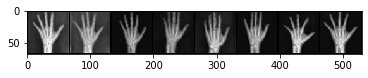

Epoch: 91	Batch: 496/497
Loss G: 10.214349746704102
Loss D: 0.6434177160263062
Epoch: 92/150
Example images:


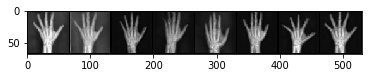

Epoch: 92	Batch: 496/497
Loss G: 8.57486629486084
Loss D: 0.000844866968691349
Epoch: 93/150
Example images:


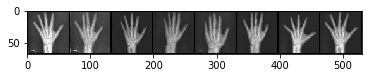

Epoch: 93	Batch: 496/497
Loss G: 13.314679145812988
Loss D: 0.4306686222553253
Epoch: 94/150
Example images:


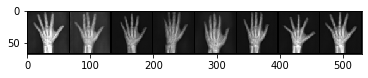

Epoch: 94	Batch: 496/497
Loss G: 7.228564739227295
Loss D: 0.012192773632705212
Epoch: 95/150
Example images:


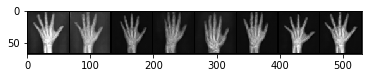

Epoch: 95	Batch: 496/497
Loss G: 10.646854400634766
Loss D: 0.039217814803123474
Epoch: 96/150
Example images:


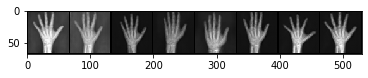

Epoch: 96	Batch: 496/497
Loss G: 12.104080200195312
Loss D: 0.0009965552017092705
Epoch: 97/150
Example images:


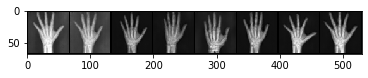

Epoch: 97	Batch: 496/497
Loss G: 6.323117733001709
Loss D: 0.009866058826446533
Epoch: 98/150
Example images:


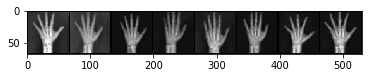

Epoch: 98	Batch: 496/497
Loss G: 9.946908950805664
Loss D: 0.0003035012923646718
Epoch: 99/150
Example images:


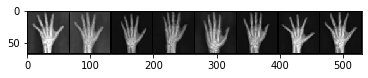

Epoch: 99	Batch: 496/497
Loss G: 11.663482666015625
Loss D: 0.0005496249068528414
Epoch: 100/150
Example images:


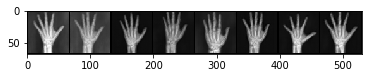

Epoch: 100	Batch: 496/497
Loss G: 7.7584123611450195
Loss D: 0.0017286319052800536
Epoch: 101/150
Example images:


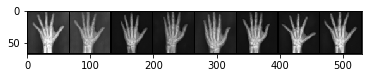

Epoch: 101	Batch: 496/497
Loss G: 9.892677307128906
Loss D: 0.0016217108350247145
Epoch: 102/150
Example images:


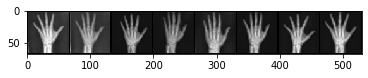

Epoch: 102	Batch: 496/497
Loss G: 14.175152778625488
Loss D: 0.08589128404855728
Epoch: 103/150
Example images:


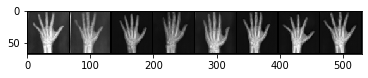

Epoch: 103	Batch: 496/497
Loss G: 11.2613525390625
Loss D: 0.19667883217334747
Epoch: 104/150
Example images:


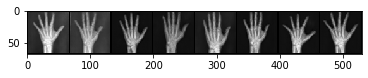

Epoch: 104	Batch: 496/497
Loss G: 9.908609390258789
Loss D: 0.007764431647956371
Epoch: 105/150
Example images:


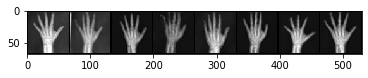

Epoch: 105	Batch: 496/497
Loss G: 11.503003120422363
Loss D: 0.00014144173474051058
Epoch: 106/150
Example images:


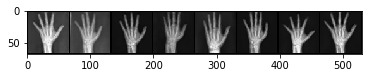

Epoch: 106	Batch: 496/497
Loss G: 6.837909698486328
Loss D: 0.008302193135023117
Epoch: 107/150
Example images:


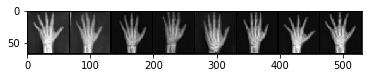

Epoch: 107	Batch: 496/497
Loss G: 10.570084571838379
Loss D: 0.00042267030221410096
Epoch: 108/150
Example images:


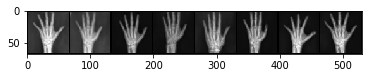

Epoch: 108	Batch: 496/497
Loss G: 14.006415367126465
Loss D: 0.13599784672260284
Epoch: 109/150
Example images:


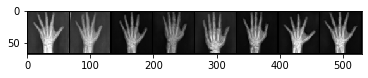

Epoch: 109	Batch: 496/497
Loss G: 12.166119575500488
Loss D: 0.00039446537266485393
Epoch: 110/150
Example images:


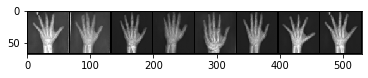

Epoch: 110	Batch: 496/497
Loss G: 9.911796569824219
Loss D: 0.0007217153324745595
Epoch: 111/150
Example images:


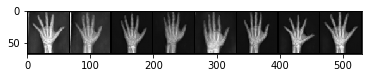

Epoch: 111	Batch: 496/497
Loss G: 15.517059326171875
Loss D: 0.5565404295921326
Epoch: 112/150
Example images:


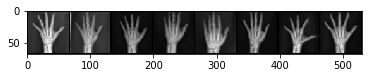

Epoch: 112	Batch: 496/497
Loss G: 16.179929733276367
Loss D: 0.06527556478977203
Epoch: 113/150
Example images:


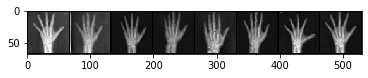

Epoch: 113	Batch: 496/497
Loss G: 8.680174827575684
Loss D: 0.0004078955971635878
Epoch: 114/150
Example images:


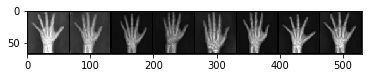

Epoch: 114	Batch: 496/497
Loss G: 6.268741607666016
Loss D: 0.01616659015417099
Epoch: 115/150
Example images:


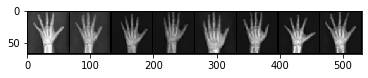

Epoch: 115	Batch: 496/497
Loss G: 12.87629222869873
Loss D: 0.7376890778541565
Epoch: 116/150
Example images:


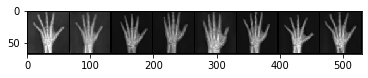

Epoch: 116	Batch: 496/497
Loss G: 5.206353664398193
Loss D: 0.028456125408411026
Epoch: 117/150
Example images:


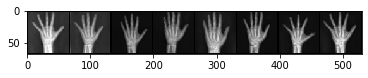

Epoch: 117	Batch: 496/497
Loss G: 10.252960205078125
Loss D: 0.06376539170742035
Epoch: 118/150
Example images:


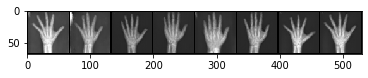

Epoch: 118	Batch: 496/497
Loss G: 8.165257453918457
Loss D: 0.017997706308960915
Epoch: 119/150
Example images:


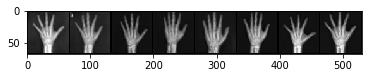

Epoch: 119	Batch: 496/497
Loss G: 8.994927406311035
Loss D: 0.003249895991757512
Epoch: 120/150
Example images:


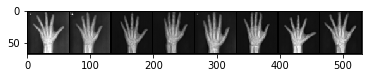

Epoch: 120	Batch: 496/497
Loss G: 8.01073932647705
Loss D: 0.10412905365228653
Epoch: 121/150
Example images:


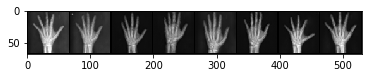

Epoch: 121	Batch: 496/497
Loss G: 12.33051586151123
Loss D: 0.41517218947410583
Epoch: 122/150
Example images:


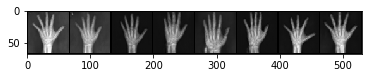

Epoch: 122	Batch: 496/497
Loss G: 16.230085372924805
Loss D: 0.008279061876237392
Epoch: 123/150
Example images:


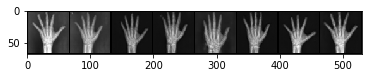

Epoch: 123	Batch: 496/497
Loss G: 9.382779121398926
Loss D: 0.0014425588306039572
Epoch: 124/150
Example images:


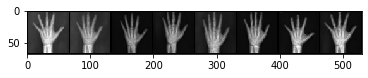

Epoch: 124	Batch: 496/497
Loss G: 20.150840759277344
Loss D: 0.03045758605003357
Epoch: 125/150
Example images:


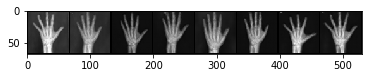

Epoch: 125	Batch: 496/497
Loss G: 7.370993137359619
Loss D: 0.0019178984221071005
Epoch: 126/150
Example images:


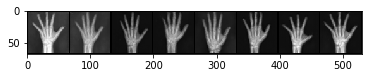

Epoch: 126	Batch: 496/497
Loss G: 6.508309841156006
Loss D: 0.0416901595890522
Epoch: 127/150
Example images:


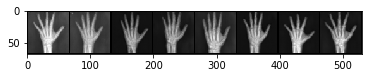

Epoch: 127	Batch: 496/497
Loss G: 5.7505998611450195
Loss D: 0.006966692395508289
Epoch: 128/150
Example images:


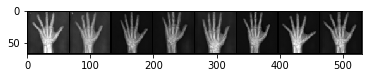

Epoch: 128	Batch: 496/497
Loss G: 6.145923137664795
Loss D: 0.01041494496166706
Epoch: 129/150
Example images:


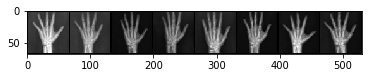

Epoch: 129	Batch: 496/497
Loss G: 10.238245964050293
Loss D: 0.00017885479610413313
Epoch: 130/150
Example images:


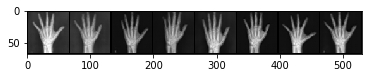

Epoch: 130	Batch: 496/497
Loss G: 4.44263219833374
Loss D: 0.007560554891824722
Epoch: 131/150
Example images:


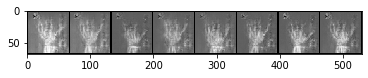

Epoch: 131	Batch: 496/497
Loss G: 6.979671001434326
Loss D: 0.001569091691635549
Epoch: 132/150
Example images:


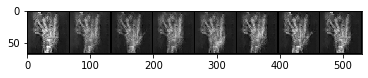

Epoch: 132	Batch: 496/497
Loss G: 13.6268310546875
Loss D: 0.0022938670590519905
Epoch: 133/150
Example images:


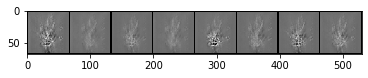

Epoch: 133	Batch: 496/497
Loss G: 9.444994926452637
Loss D: 0.0047378093004226685
Epoch: 134/150
Example images:


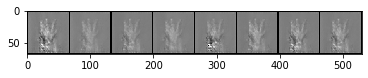

Epoch: 134	Batch: 496/497
Loss G: 55.94839096069336
Loss D: 0.0
Epoch: 135/150
Example images:


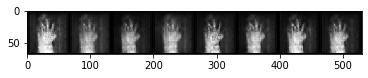

Epoch: 135	Batch: 496/497
Loss G: 70.32823944091797
Loss D: 0.0
Epoch: 136/150
Example images:


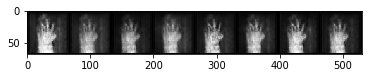

Epoch: 136	Batch: 496/497
Loss G: 26.036291122436523
Loss D: 0.00011324868683004752
Epoch: 137/150
Example images:


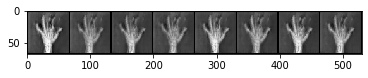

Epoch: 137	Batch: 496/497
Loss G: 54.152462005615234
Loss D: 0.0
Epoch: 138/150
Example images:


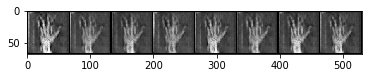

Epoch: 138	Batch: 496/497
Loss G: 46.5403938293457
Loss D: 0.0
Epoch: 139/150
Example images:


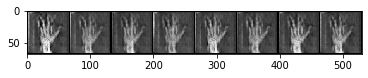

Epoch: 139	Batch: 496/497
Loss G: 45.62947082519531
Loss D: 0.0
Epoch: 140/150
Example images:


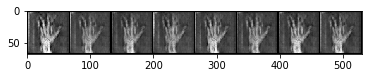

Epoch: 140	Batch: 496/497
Loss G: 45.898006439208984
Loss D: 0.0
Epoch: 141/150
Example images:


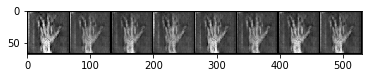

Epoch: 141	Batch: 496/497
Loss G: 41.0499153137207
Loss D: 0.0
Epoch: 142/150
Example images:


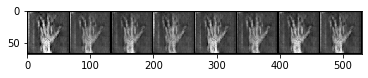

Epoch: 142	Batch: 496/497
Loss G: 43.81765365600586
Loss D: 0.0
Epoch: 143/150
Example images:


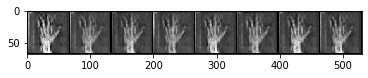

Epoch: 143	Batch: 496/497
Loss G: 40.9909553527832
Loss D: 0.0
Epoch: 144/150
Example images:


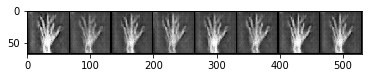

Epoch: 144	Batch: 496/497
Loss G: 25.823246002197266
Loss D: 0.011140093207359314
Epoch: 145/150
Example images:


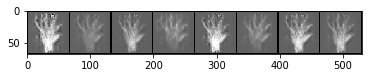

Epoch: 145	Batch: 496/497
Loss G: 18.30863380432129
Loss D: 9.203060471918434e-06
Epoch: 146/150
Example images:


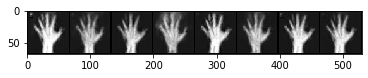

Epoch: 146	Batch: 496/497
Loss G: 12.12346363067627
Loss D: 0.00036920461570844054
Epoch: 147/150
Example images:


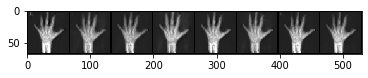

Epoch: 147	Batch: 496/497
Loss G: 56.988624572753906
Loss D: 7.152558367806705e-08
Epoch: 148/150
Example images:


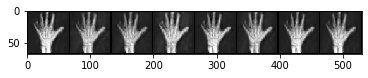

Epoch: 148	Batch: 496/497
Loss G: 55.1248664855957
Loss D: 7.152558367806705e-08
Epoch: 149/150
Example images:


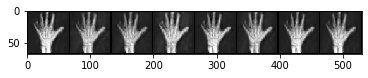

Epoch: 149	Batch: 496/497
Loss G: 56.77254867553711
Loss D: 7.152558367806705e-08


In [14]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch}/{n_epochs}")
    print("Example images:")
    generated_images = G(test_noise).detach().cpu()
    show_images(generated_images)
    
    for i, (batch, _) in enumerate(data_loader):
        print(f"\rEpoch: {epoch}\tBatch: {i}/{len(data_loader)}", end='')
        ####
        D.zero_grad()

        #
        real = Variable(batch).to(gpu)
        real_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(gpu)
        real_predictions = D(real)
        d_error_real = compute_loss(real_predictions, real_labels)
        
        # 
        noise = Variable(torch.randn(real.size(0), 100, 1, 1)).to(gpu)
        fake = G(noise)
        fake_predictions = D(fake.detach())
        fake_labels = Variable(torch.zeros(real.size(0), 1, 1, 1)).to(gpu)
        d_error_fake = compute_loss(fake_predictions, fake_labels)
        
        # 
        d_error_total = d_error_real + d_error_fake
        d_error_total.backward()
        optimizer_d.step()
        
        ####
        G.zero_grad()
        
        # 
        goal_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(gpu)
        results = D(fake)
        g_error = compute_loss(results, goal_labels)
        
        # 
        g_error.backward()
        optimizer_g.step()
    
    print("")
    print(f"Loss G: {g_error}")
    print(f"Loss D: {d_error_total}")

In [15]:
torch.save(G.state_dict(), "tmdhey_trained_generator")
torch.save(D.state_dict(), "tmdhey_trained_discriminator")

In [16]:
torch.save(G.state_dict(), "/content/drive/MyDrive/cakd_colab/python_practice/tmdhey_trained_generator")
torch.save(D.state_dict(), "/content/drive/MyDrive/cakd_colab/python_practice/tmdhey_trained_discriminator")

# Try trained GAN

In [ ]:
import torchvision
import torch
from torch import nn

In [ ]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            # Hidden Layer 1
            nn.ConvTranspose2d(in_channels=100, 
                               out_channels=512,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            
            # Hidden Layer 2
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            
            # Hidden Layer 3
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            # Hidden Layer 4
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            
            # Output Layer
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.main(x)
        return x

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(images):
    img = torchvision.utils.make_grid(images, normalize=True)
    npy_img = img.numpy()
    plt.imshow(np.transpose(npy_img, (1, 2, 0)),
               interpolation='nearest')
    plt.show()

In [17]:
G = Generator()
G.load_state_dict(torch.load('/content/drive/MyDrive/cakd_colab/python_practice/tmdhey_trained_generator'))

<All keys matched successfully>

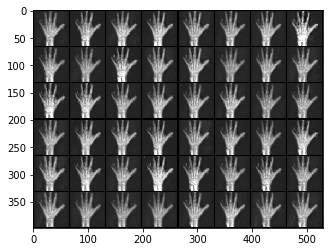

In [18]:
noise = torch.randn(48, 100, 1, 1)

images = G(noise).detach()
images.shape

show_images(images)